# Fraud Transaction Prediction with Advanced Resampling Techniques

## Project Overview
This project addresses the challenge of detecting fraudulent credit card transactions in a highly imbalanced dataset. With only 0.13% of transactions (8,213 out of 6,362,620) being fraudulent, this represents a real-world scenario where standard machine learning approaches often fail due to class imbalance.


## Methodology
I implement several advanced resampling techniques including:
- Random Under-sampling
- Random Over-sampling
- SMOTE (Synthetic Minority Over-sampling Technique)
- ADASYN (Adaptive Synthetic Sampling)

These methods help balance the dataset to improve the model's ability to detect fraudulent transactions without being overwhelmed by the majority class of legitimate transactions.


## Evaluation Strategy
Rather than relying on accuracy (which can be misleading with imbalanced data), this project focuses on more appropriate metrics:
- Accuracy
- AUC
- Precision
- F1-score
- Recall
- Confusion matrix

These metrics better capture the model's performance on the minority class that represents fraudulent transactions.


## Models Implemented

This project implements and compares three different machine learning algorithms to identify the most effective approach for fraud detection:

### Decision Tree (DT)
Decision Trees are used as both a baseline model and for their interpretability. The hierarchical structure of decision trees helps identify the most important features for fraud detection and provides clear decision paths that can be followed to understand classifications.

### XGBoost (XGB)
XGBoost is implemented as a high-performance gradient boosting framework that excels with imbalanced datasets. This ensemble technique combines multiple decision trees to create a robust model that:
- Handles the class imbalance effectively
- Provides superior classification performance on fraud transactions  
- Includes built-in regularization to prevent overfitting
- Offers feature importance rankings to enhance interpretability

### Logistic Regression (LR)
Logistic Regression serves as a probabilistic linear classifier that:
- Provides probability scores for transactions being fraudulent
- Offers excellent baseline performance when combined with resampling techniques
- Delivers high interpretability through its coefficients
- Demonstrates how simpler models can sometimes outperform complex ones when properly tuned
  

## Model Comparison
Each model is evaluated across different resampling techniques (Random Under-sampling, Random Over-sampling, SMOTE, ADASYN) to determine the optimal combination. Performance metrics are compared systematically to identify which approach yields the best balance between fraud detection (recall) and minimizing false positives (precision).


In [159]:
#Import Section
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.datasets import make_classification

# Import imbalace technique algorithims
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## Import Dataset

In [161]:
df = pd.read_csv('Fraud.csv') #upload file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [163]:
df = pd.read_csv('Fraud.csv')

## Data Understanding

In [165]:
df.head() #observation

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [167]:
df.shape

(6362620, 11)

In [169]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe() #explore statistic

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [171]:
df.describe(include='object')

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


### Find null

In [38]:
df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})

,Total No. of Missing Values
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


### Remove Duplicate

In [40]:
print("Duplicate Values =",df.duplicated().sum())

Duplicate Values = 0


In [180]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

Filter 'isFlaggedFraud' 

In [183]:
flagged_fraud = df[df['isFlaggedFraud'] == 1]

print(f"No. Flagged transaction: {len(flagged_fraud)}")
print("\nIsFlaggedFraud:")
print(flagged_fraud)

print("\nStatistic of flagged transaction:")
print(flagged_fraud.describe())

# Check all FlaggedFraud is Fraud
print("\nCheck all FlaggedFraud is Fraud:")
print(flagged_fraud['isFraud'].value_counts())

No. Flagged transaction: 16

IsFlaggedFraud:
         step      type      amount     nameOrig  oldbalanceOrg  \
2736446   212  TRANSFER  4953893.08   C728984460     4953893.08   
3247297   250  TRANSFER  1343002.08  C1100582606     1343002.08   
3760288   279  TRANSFER   536624.41  C1035541766      536624.41   
5563713   387  TRANSFER  4892193.09   C908544136     4892193.09   
5996407   425  TRANSFER 10000000.00   C689608084    19585040.37   
5996409   425  TRANSFER  9585040.37   C452586515    19585040.37   
6168499   554  TRANSFER  3576297.10   C193696150     3576297.10   
6205439   586  TRANSFER   353874.22  C1684585475      353874.22   
6266413   617  TRANSFER  2542664.27   C786455622     2542664.27   
6281482   646  TRANSFER 10000000.00    C19004745    10399045.08   
6281484   646  TRANSFER   399045.08   C724693370    10399045.08   
6296014   671  TRANSFER  3441041.46   C917414431     3441041.46   
6351225   702  TRANSFER  3171085.59  C1892216157     3171085.59   
6362460   730  TR

## Visualization

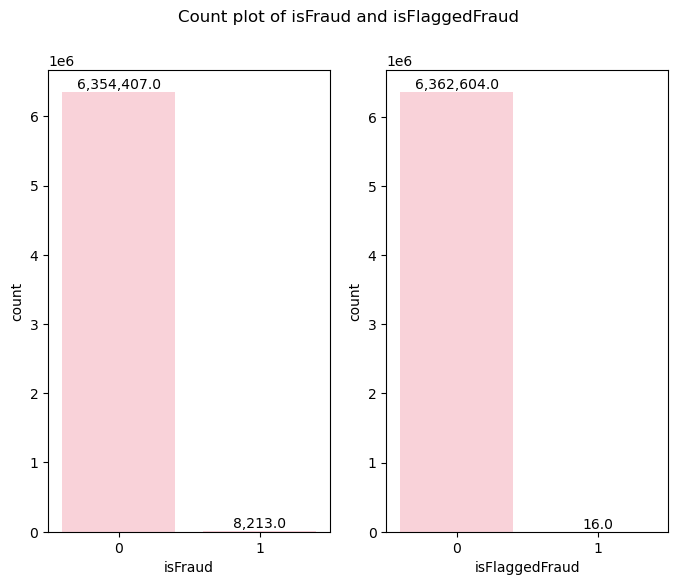

In [189]:
plt.figure(figsize=(8, 6))

# isFraud plot
plt.subplot(121)
ax = sns.countplot(data=df, x='isFraud', color='#FFCCD5')
for container in ax.containers:
   ax.bar_label(container, fmt='{:,}')  

# isFlaggedFraud plot
plt.subplot(122)
ax = sns.countplot(data=df, x='isFlaggedFraud', color='#FFCCD5')
for container in ax.containers:
   ax.bar_label(container, fmt='{:,}') 

plt.suptitle('Count plot of isFraud and isFlaggedFraud')
plt.show()

This graph highlights the extreme class imbalance in the dataset: out of over 6.3 million transactions, only 8,213 (0.13%) are actual fraud cases (left chart), while just 16 transactions were flagged as fraud by existing systems (right chart). This severe imbalance (773:1 ratio of legitimate to fraudulent transactions) demonstrates why traditional accuracy metrics would be misleading and why specialized techniques are necessary for effective fraud detection modeling.

<Axes: xlabel='count', ylabel='type'>

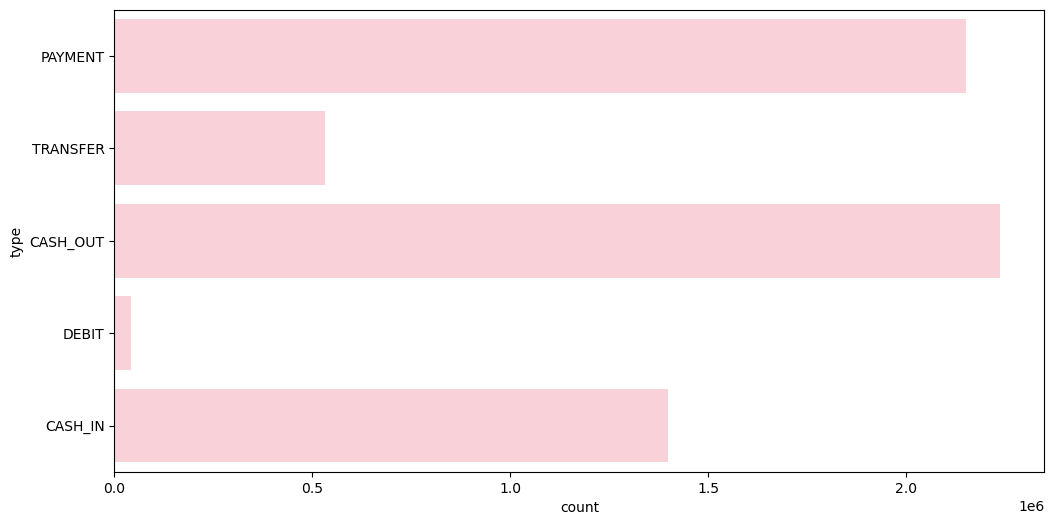

In [192]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='type', color='#FFCCD5')

This graph compares the count (frequency) of different transaction types in the dataset. PAYMENT and CASH_OUT are the most common types, followed by CASH_IN, then TRANSFER, while DEBIT transactions are extremely rare.

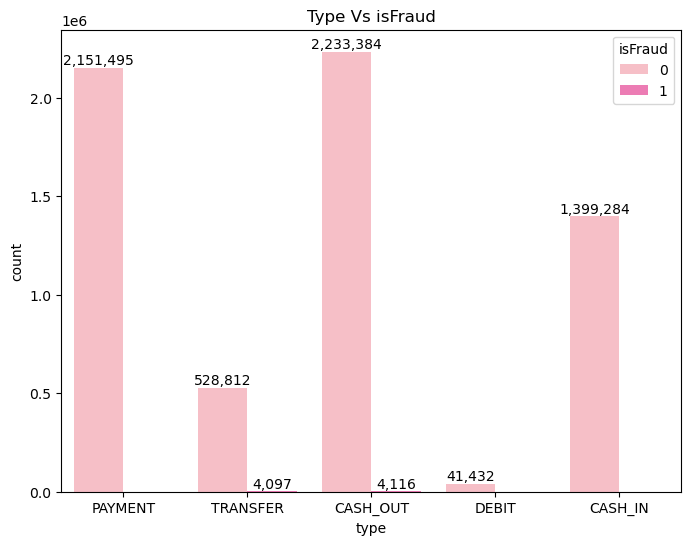

In [195]:
# Countplot of type feature
plt.figure(figsize=(8,6))

colors = ['#FFB6C1', '#FF69B4']

ax = sns.countplot(data=df, x='type', hue='isFraud', palette=colors)

for i in range(len(ax.containers)):
   ax.bar_label(ax.containers[i], fmt='{:,.0f}')

plt.title('Type Vs isFraud')
plt.show()

This graph compares transaction types versus fraud status. The light pink bars show legitimate transactions (isFraud = 0) and the darker pink (barely visible) represent fraudulent transactions (isFraud = 1). CASH_OUT and PAYMENT are the most common transaction types, with DEBIT being the rarest.

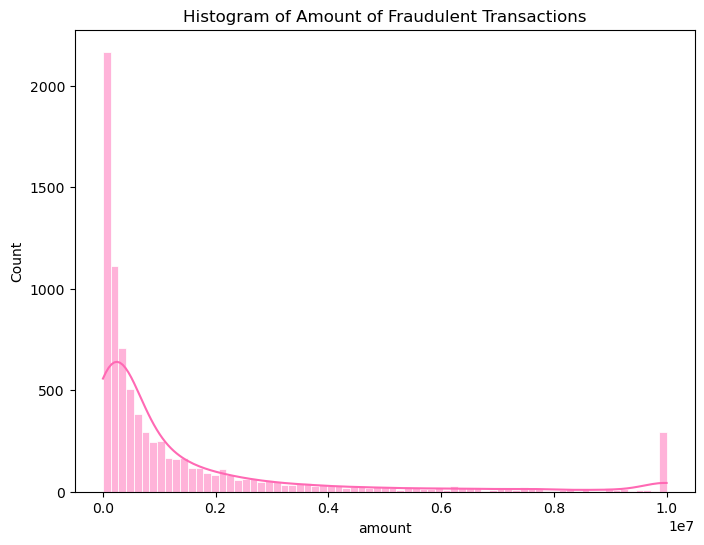

In [198]:
# Histogram of Amount feature based on fraud
plt.figure(figsize=(8,6))

sns.histplot(
   data=df[df['isFraud']==1],
   x='amount',
   kde=True,
   color='#FF69B4',  
   edgecolor='white'  
)

plt.title('Histogram of Amount of Fraudulent Transactions')
plt.show()

This histogram shows the distribution of transaction amounts for fraudulent transactions. Most fraudulent activities occur with smaller amounts (clustered near zero), showing a right-skewed distribution. There's also a small spike of fraudulent transactions at the high end (near 10 million), suggesting two distinct fraud patterns: high-volume small transactions and fewer large-value frauds.

In [201]:
# Select only numeric data
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_columns].corr()

In [203]:
print("\nNumeric columns:")
print(list(numeric_columns))


Numeric columns:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


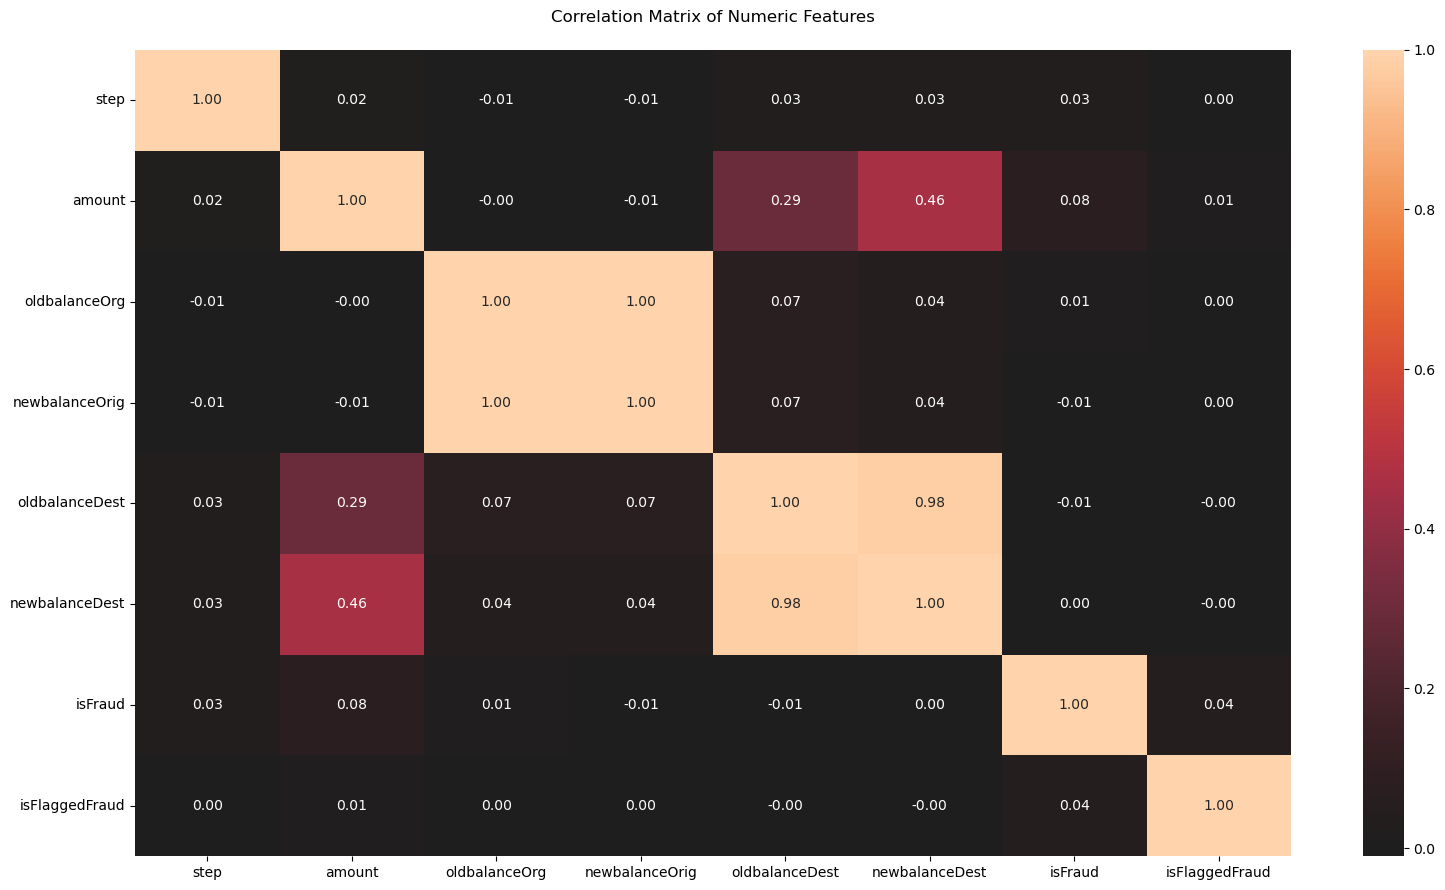

In [205]:
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix,
           annot=True, 
           center=0,
           fmt='.2f')  

plt.title('Correlation Matrix of Numeric Features', pad=20)

plt.tight_layout()


The correlation matrix clearly shows that no single feature has a strong relationship with fraud, as evidenced by the very low correlation values between isFraud and all other variables (highest being only 0.08 with amount). This suggests that fraudulent transactions cannot be detected through simple linear relationships with individual features, highlighting why advanced modeling techniques like ensemble methods and resampling approaches are necessary for effective fraud detection in this dataset.

## Data Preprocessing

### Feature selection

- Added time-based features by converting the 'step' column into:

'hour': Extracting hour information (step % 24)
'day': Extracting day information (step // 24)


- Created merchant identifier feature:

'isMerchant': Boolean flag (0/1) identifying if destination accounts are merchants, by checking if 'nameDest' starts with 'M'


- Added balance change features:

'ChangeOrg': Absolute difference between old and new origin account balances
'ChangeDest': Absolute difference between old and new destination account balances


- Created amount discrepancy features:

'DiffAmountOrg': Absolute difference between account balance change and transaction amount for origin account
'DiffAmountDest': Absolute difference between account balance change and transaction amount for destination account


- Reorganized the target variable:

Temporarily removed 'isFraud' column and reinserted it to position it at the end of the dataframe for better model training organization

In [212]:
#transform data in to day and hour format
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24 

In [214]:
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

In [216]:
df['ChangeOrg'] = abs(df['oldbalanceOrg'] - df['newbalanceOrig'])
df['ChangeDest'] = abs(df['oldbalanceDest'] - df['newbalanceDest'])

In [218]:
df['DiffAmountOrg'] = abs(df['ChangeOrg'] - df['amount'])
df['DiffAmountDest'] = abs(df['ChangeDest'] - df['amount'])

In [220]:
fraud_column = df.pop('isFraud')
df['isFraud'] = fraud_column

In [222]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,hour,day,isMerchant,ChangeOrg,ChangeDest,DiffAmountOrg,DiffAmountDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,1,0,1,9839.64,0.00,0.00,9839.64,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,1,0,1,1864.28,0.00,0.00,1864.28,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,1,0,0,181.00,0.00,0.00,181.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1,0,0,181.00,21182.00,0.00,21001.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,1,0,1,11668.14,0.00,0.00,11668.14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,23,30,0,339682.13,339682.13,0.00,0.00,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,23,30,0,6311409.28,0.00,0.00,6311409.28,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,23,30,0,6311409.28,6311409.27,0.00,0.01,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,23,30,0,850002.52,0.00,0.00,850002.52,1


In [224]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFlaggedFraud          2
hour                   24
day                    31
isMerchant              2
ChangeOrg         2942732
ChangeDest        3965873
DiffAmountOrg     3345137
DiffAmountDest    2145270
isFraud                 2
dtype: int64

### Visualization

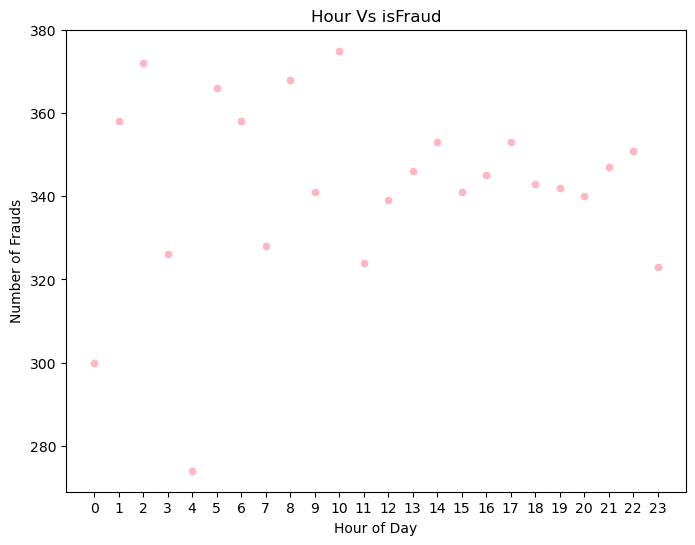

In [227]:
hour_group = df.groupby('hour')['isFraud'].sum().reset_index()
plt.figure(figsize=(8,6))
sns.scatterplot(data=hour_group, x='hour', y='isFraud', color='#FFB6C1')

plt.title('Hour Vs isFraud')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Frauds')

plt.xticks(range(0,24))

plt.show()

The scatter plot shows the number of fraudulent transactions across different hours of the day (0-23). The distribution appears relatively uniform with no clear pattern or relationship between the hour of day and fraud frequency. 

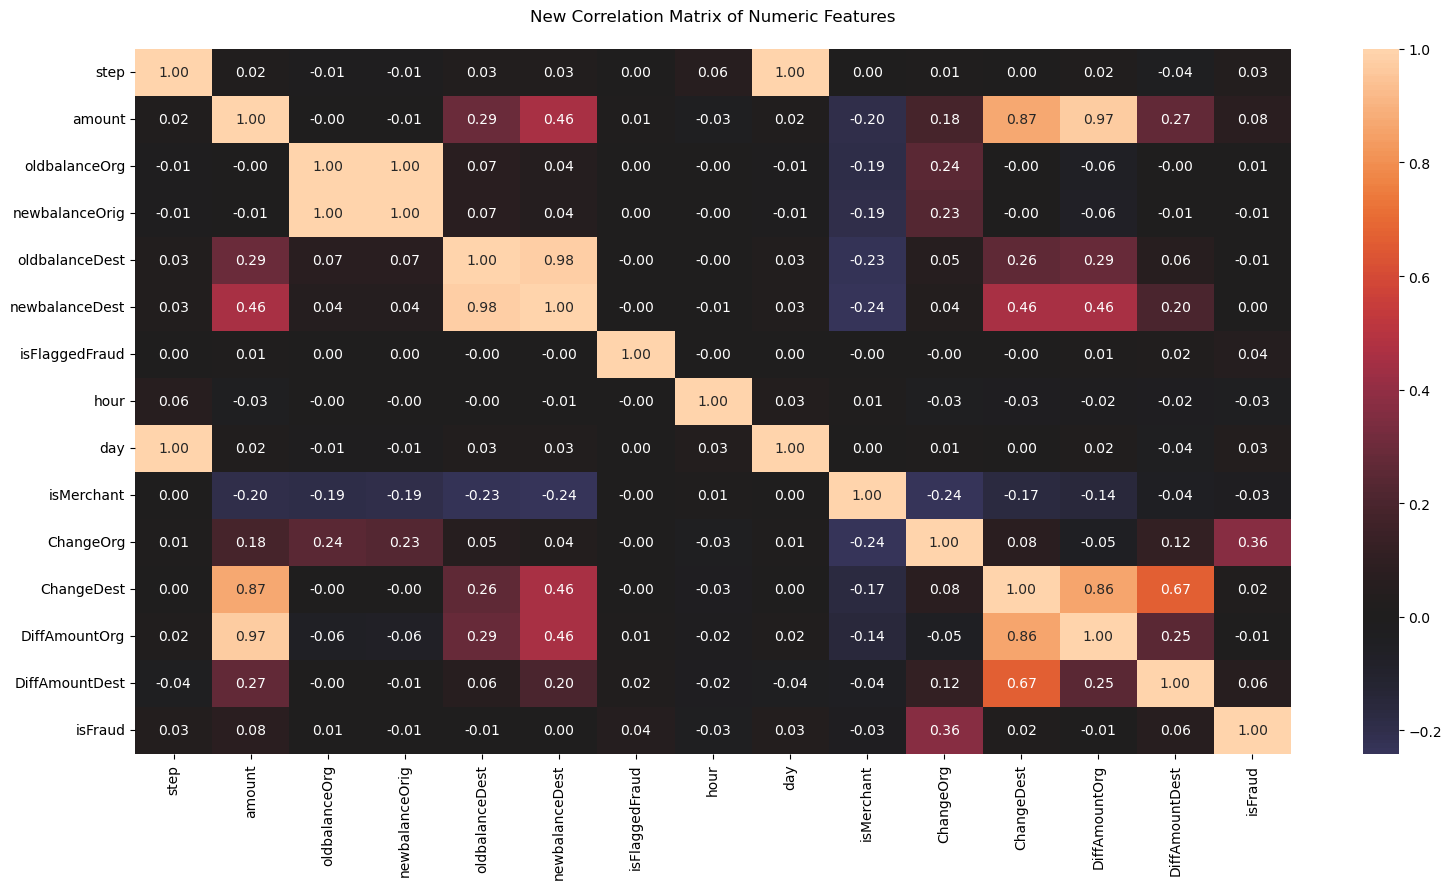

In [230]:
numeric_columns_add = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix_add = df[numeric_columns_add].corr()

plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix_add,
           annot=True, 
           center=0,
           fmt='.2f') 

plt.title('New Correlation Matrix of Numeric Features', pad=20)

plt.tight_layout()

### Remove Outlier

We shouldn't remove any outlier due to fraud data usually be an outlier and remove it may loss a significant fraud data

### Encoding Categorical Data

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 18 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFlaggedFraud  int64  
 10  hour            int64  
 11  day             int64  
 12  isMerchant      int64  
 13  ChangeOrg       float64
 14  ChangeDest      float64
 15  DiffAmountOrg   float64
 16  DiffAmountDest  float64
 17  isFraud         int64  
dtypes: float64(9), int64(6), object(3)
memory usage: 873.8+ MB


In [240]:
# encoding type
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [241]:
le = LabelEncoder()
df['nameOrig'] = le.fit_transform(df['nameOrig'])
df['nameDest'] = le.fit_transform(df['nameDest'])

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 18 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFlaggedFraud  int64  
 10  hour            int64  
 11  day             int64  
 12  isMerchant      int64  
 13  ChangeOrg       float64
 14  ChangeDest      float64
 15  DiffAmountOrg   float64
 16  DiffAmountDest  float64
 17  isFraud         int64  
dtypes: float64(9), int64(9)
memory usage: 873.8 MB


### Missing Value and Duplicate Value

(There are no Missing and Duplicate Value (Can see in Data Observation Section))

### Feature Scaling

In [250]:
columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
                    'ChangeOrg', 'ChangeDest', 'DiffAmountOrg', 'DiffAmountDest']

scaler = MinMaxScaler()

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [252]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,hour,day,isMerchant,ChangeOrg,ChangeDest,DiffAmountOrg,DiffAmountDest,isFraud
0,1,3,0.00,757869,0.00,0.00,1662094,0.00,0.00,0,1,0,1,0.00,0.00,0.00,0.00,0
1,1,3,0.00,2188998,0.00,0.00,1733924,0.00,0.00,0,1,0,1,0.00,0.00,0.00,0.00,0
2,1,4,0.00,1002156,0.00,0.00,439685,0.00,0.00,0,1,0,0,0.00,0.00,0.00,0.00,1
3,1,1,0.00,5828262,0.00,0.00,391696,0.00,0.00,0,1,0,0,0.00,0.00,0.00,0.00,1
4,1,3,0.00,3445981,0.00,0.00,828919,0.00,0.00,0,1,0,1,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,0.00,5651847,0.01,0.00,505863,0.00,0.00,0,23,30,0,0.03,0.00,0.00,0.00,1
6362616,743,4,0.07,1737278,0.11,0.00,260949,0.00,0.00,0,23,30,0,0.63,0.00,0.00,0.08,1
6362617,743,1,0.07,533958,0.11,0.00,108224,0.00,0.02,0,23,30,0,0.63,0.06,0.00,0.00,1
6362618,743,4,0.01,2252932,0.01,0.00,319713,0.00,0.00,0,23,30,0,0.09,0.00,0.00,0.01,1


### Data Split X and y

In [255]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']

In [257]:
#check
y.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

### Data Spliting

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=101)

In [262]:
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (5090096, 17)
y_train -  (5090096,)
X_test -  (1272524, 17)
y_test -  (1272524,)


## Data imbalance

### Undersampled

In [266]:
random_state = 42

rus = RandomUnderSampler(random_state=random_state)
X_res, y_res = rus.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train_under = X_res
y_train_under = y_res

X_test_under, y_test_under = X_test, y_test

print("X_train_under - ",X_train_under.shape)
print("y_train_under - ",y_train_under.shape)
print("X_test_under - ",X_test_under.shape)
print("y_test_under - ",y_test_under.shape)

Resampled dataset shape Counter({0: 6586, 1: 6586})
X_train_under -  (13172, 17)
y_train_under -  (13172,)
X_test_under -  (1272524, 17)
y_test_under -  (1272524,)


### Oversampled

In [269]:
random_state = 42

ros = RandomOverSampler(random_state=random_state)
X_res, y_res = ros.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_train_over = X_res
y_train_over = y_res
X_test_over, y_test_over = X_test, y_test

print("X_train_over - ",X_train_over.shape)
print("y_train_over - ",y_train_over.shape)
print("X_test_over - ",X_test_over.shape)
print("y_test_over - ",y_test_over.shape)

Resampled dataset shape Counter({0: 5083510, 1: 5083510})
X_train_over -  (10167020, 17)
y_train_over -  (10167020,)
X_test_over -  (1272524, 17)
y_test_over -  (1272524,)


### SMOTE

In [272]:
random_state = 42

smote = SMOTE(random_state=42)
X_res, y_res  = smote.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

X_train_smote = X_res
y_train_smote = y_res
X_test_smote, y_test_smote = X_test, y_test

print("X_train_smote - ",X_train_smote.shape)
print("y_train_smote - ",y_train_smote.shape)
print("X_test_smote - ",X_test_smote.shape)
print("y_test_smote - ",y_test_smote.shape)

Resampled dataset shape Counter({0: 5083510, 1: 5083510})
X_train_smote -  (10167020, 17)
y_train_smote -  (10167020,)
X_test_smote -  (1272524, 17)
y_test_smote -  (1272524,)


### ADASYN

In [277]:
random_state = 42

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

X_train_adasyn = X_res
y_train_adasyn = y_res
X_test_adasyn, y_test_adasyn = X_test, y_test

print("X_train_adasyn - ",X_train_adasyn.shape) 
print("y_train_adasyn - ",y_train_adasyn.shape)
print("X_test_adasyn - ",X_test_adasyn.shape)
print("y_test_adasyn - ",y_test_adasyn.shape)

Resampled dataset shape Counter({0: 5083510, 1: 5080968})
X_train_adasyn -  (10164478, 17)
y_train_adasyn -  (10164478,)
X_test_adasyn -  (1272524, 17)
y_test_adasyn -  (1272524,)


## Modeling

In [281]:
pip install xgboost


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [283]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
from xgboost import XGBClassifier

In [286]:
names_lst = []

# Empty list to capture performance matrix for train set
aucs_train_lst = []
accuracy_train_lst = []
precision_train_lst = []
recall_train_lst = []
f1_train_lst = []

# Empty list to capture performance matrix for test set
aucs_test_lst = []
accuracy_test_lst = []
precision_test_lst = []
recall_test_lst = []
f1_test_lst = []

# Function for model building and performance measure

def build_measure_model(models):
    #plt.figure(figsize=(12,6))

    for name, model, X_train, X_test, y_train, y_test in models:

        names_lst.append(name)

        # split data in train test set
        X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test

        # Build model
        model.fit(X_train, y_train)

        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # calculate accuracy
        Accuracy_train = metrics.accuracy_score(y_train, y_train_pred)
        accuracy_train_lst.append(Accuracy_train)

        Accuracy_test = metrics.accuracy_score(y_test, y_test_pred)
        accuracy_test_lst.append(Accuracy_test)

        # calculate auc
        Aucs_train = metrics.roc_auc_score(y_train, y_train_pred)
        aucs_train_lst.append(Aucs_train)

        Aucs_test = metrics.roc_auc_score(y_test , y_test_pred)
        aucs_test_lst.append(Aucs_test)

        # calculate precision
        PrecisionScore_train = metrics.precision_score(y_train , y_train_pred)
        precision_train_lst.append(PrecisionScore_train)

        PrecisionScore_test = metrics.precision_score(y_test , y_test_pred)
        precision_test_lst.append(PrecisionScore_test)

        # calculate recall
        RecallScore_train = metrics.recall_score(y_train , y_train_pred)
        recall_train_lst.append(RecallScore_train)

        RecallScore_test = metrics.recall_score(y_test , y_test_pred)
        recall_test_lst.append(RecallScore_test)

        # calculate f1 score
        F1Score_train = metrics.f1_score(y_train , y_train_pred)
        f1_train_lst.append(F1Score_train)

        F1Score_test = metrics.f1_score(y_test , y_test_pred)
        f1_test_lst.append(F1Score_test)

        #print('F1 Score of '+ name +' model : {0:0.5f}'.format(F1Score_test))

        # draw confusion matrix
        cnf_matrix = metrics.confusion_matrix(y_test , y_test_pred)

        print("Model Name :", name)

        #print('Train Accuracy :{0:0.5f}'.format(Accuracy_train))
        print('Test Accuracy :{0:0.5f}'.format(Accuracy_test))

        #print('Train AUC : {0:0.5f}'.format(Aucs_train))
        print('Test AUC : {0:0.5f}'.format(Aucs_test))

        #print('Train Precision : {0:0.5f}'.format(PrecisionScore_train))
        print('Test Precision : {0:0.5f}'.format(PrecisionScore_test))

        #print('Train Recall : {0:0.5f}'.format(RecallScore_train))
        print('Test Recall : {0:0.5f}'.format(RecallScore_test))

        #print('Train F1 : {0:0.5f}'.format(F1Score_train))
        print('Test F1 : {0:0.5f}'.format(F1Score_test))

        print('Confusion Matrix : \n', cnf_matrix)
        print("\n")

This code creates a systematic evaluation framework for comparing model performance across multiple metrics (accuracy, AUC, precision, recall, F1) on both training and test sets. It's designed to consistently measure and track how different fraud detection models (Decision Tree, XGBoost, Logistic Regression) perform, with special focus on metrics that matter for imbalanced datasets. The function handles model fitting, prediction, and comprehensive performance evaluation, making it easy to identify which approach works best for fraud detection.

### Logistic Regression (LR)

In [290]:
LRmodels = []

#LRmodels.append(('LR imbalance', LogisticRegression(solver='liblinear', multi_class='ovr'),X,y))
LRmodels.append(('LR Undersampling', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_under, X_test_under, y_train_under, y_test_under))
LRmodels.append(('LR Oversampling', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_over, X_test_over, y_train_over, y_test_over))
LRmodels.append(('LR SMOTE', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_smote, X_test_smote, y_train_smote, y_test_smote))
LRmodels.append(('LR ADASYN', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn))

# Call function to create model and measure its performance
build_measure_model(LRmodels)

Model Name : LR Undersampling
Test Accuracy :0.62163
Test AUC : 0.66601
Test Precision : 0.00240
Test Recall : 0.71051
Test F1 : 0.00478
Confusion Matrix : 
 [[789878 481019]
 [   471   1156]]


Model Name : LR Oversampling
Test Accuracy :0.61989
Test AUC : 0.66606
Test Precision : 0.00239
Test Recall : 0.71235
Test F1 : 0.00477
Confusion Matrix : 
 [[787669 483228]
 [   468   1159]]


Model Name : LR SMOTE
Test Accuracy :0.62409
Test AUC : 0.66448
Test Precision : 0.00239
Test Recall : 0.70498
Test F1 : 0.00477
Confusion Matrix : 
 [[793025 477872]
 [   480   1147]]


Model Name : LR ADASYN
Test Accuracy :0.62442
Test AUC : 0.66465
Test Precision : 0.00240
Test Recall : 0.70498
Test F1 : 0.00478
Confusion Matrix : 
 [[793445 477452]
 [   480   1147]]




### Decision Tree (DT)

In [292]:
DTmodels = []

dt = DecisionTreeClassifier()

#DTmodels.append(('DT imbalance', dt,X,y))
DTmodels.append(('DT Undersampling', dt, X_train_under, X_test_under, y_train_under, y_test_under))
DTmodels.append(('DT Oversampling', dt,X_train_over, X_test_over, y_train_over, y_test_over))
DTmodels.append(('DT SMOTE', dt,X_train_smote, X_test_smote, y_train_smote, y_test_smote))
DTmodels.append(('DT ADASYN', dt ,X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn))

# Call function to create model and measure its performance
build_measure_model(DTmodels)

Model Name : DT Undersampling
Test Accuracy :0.99657
Test AUC : 0.99706
Test Precision : 0.27127
Test Recall : 0.99754
Test F1 : 0.42654
Confusion Matrix : 
 [[1266537    4360]
 [      4    1623]]


Model Name : DT Oversampling
Test Accuracy :0.99997
Test AUC : 0.99262
Test Precision : 0.98768
Test Recall : 0.98525
Test F1 : 0.98646
Confusion Matrix : 
 [[1270877      20]
 [     24    1603]]


Model Name : DT SMOTE
Test Accuracy :0.99973
Test AUC : 0.99588
Test Precision : 0.83110
Test Recall : 0.99201
Test F1 : 0.90446
Confusion Matrix : 
 [[1270569     328]
 [     13    1614]]


Model Name : DT ADASYN
Test Accuracy :0.99977
Test AUC : 0.99375
Test Precision : 0.85388
Test Recall : 0.98771
Test F1 : 0.91593
Confusion Matrix : 
 [[1270622     275]
 [     20    1607]]




### xgboost (XGB)

In [294]:
XGBmodels = []

#XGBmodels.append(('XGB imbalance', XGBClassifier(),X,y))
XGBmodels.append(('XGB Undersampling', XGBClassifier(),X_train_under, X_test_under, y_train_under, y_test_under))
XGBmodels.append(('XGB Oversampling', XGBClassifier(),X_train_over, X_test_over, y_train_over, y_test_over))
XGBmodels.append(('XGB SMOTE', XGBClassifier(),X_train_smote, X_test_smote, y_train_smote, y_test_smote))
XGBmodels.append(('XGB ADASYN', XGBClassifier(),X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn))

# Call function to create model and measure its performance
build_measure_model(XGBmodels)

Model Name : XGB Undersampling
Test Accuracy :0.99889
Test AUC : 0.99822
Test Precision : 0.53529
Test Recall : 0.99754
Test F1 : 0.69672
Confusion Matrix : 
 [[1269488    1409]
 [      4    1623]]


Model Name : XGB Oversampling
Test Accuracy :0.99984
Test AUC : 0.99439
Test Precision : 0.89488
Test Recall : 0.98894
Test F1 : 0.93956
Confusion Matrix : 
 [[1270708     189]
 [     18    1609]]


Model Name : XGB SMOTE
Test Accuracy :0.99981
Test AUC : 0.99438
Test Precision : 0.87828
Test Recall : 0.98894
Test F1 : 0.93033
Confusion Matrix : 
 [[1270674     223]
 [     18    1609]]


Model Name : XGB ADASYN
Test Accuracy :0.99982
Test AUC : 0.99408
Test Precision : 0.88644
Test Recall : 0.98832
Test F1 : 0.93461
Confusion Matrix : 
 [[1270691     206]
 [     19    1608]]




## Result

In [298]:
# Display comparison of the models performance

data = {'Model':names_lst,
       #'Accuracy_Train':accuracy_train_lst,
       #'Accuracy_Test':accuracy_test_lst,
       #'AUC_Train':aucs_train_lst,
       #'AUC_Test':aucs_test_lst,
       #'PrecisionScore_Train':precision_train_lst,
       'PrecisionScore_Test':precision_test_lst,
       #'RecallScore_Train':recall_train_lst,
       'RecallScore_Test':recall_test_lst,
       #'F1Score_Train':f1_train_lst,
       'F1Score_Test':f1_test_lst}

print("Performance measures of various classifiers: \n")
performance_df = pd.DataFrame(data) 
performance_df.sort_values(['F1Score_Test'],ascending=False)

Performance measures of various classifiers: 



,Model,PrecisionScore_Test,RecallScore_Test,F1Score_Test
5,DT Oversampling,0.99,0.99,0.99
9,XGB Oversampling,0.89,0.99,0.94
11,XGB ADASYN,0.89,0.99,0.93
10,XGB SMOTE,0.88,0.99,0.93
7,DT ADASYN,0.85,0.99,0.92
6,DT SMOTE,0.83,0.99,0.90
8,XGB Undersampling,0.54,1.00,0.70
4,DT Undersampling,0.27,1.00,0.43
0,LR Undersampling,0.00,0.71,0.00
3,LR ADASYN,0.00,0.70,0.00


# Model Performance Analysis

## Results Summary
The table above ranks models by F1-Score (highest to lowest), providing a clear comparison of model performance across different algorithms and resampling techniques.

## Key Findings:

### Top Performing Models
- **Decision Tree with Oversampling** achieved the highest performance metrics (Precision: 0.99, Recall: 0.99, F1-Score: 0.99), demonstrating exceptional ability to detect fraudulent transactions while minimizing false positives.
- **XGBoost with resampling techniques** (Oversampling, ADASYN, SMOTE) delivered consistently strong results with F1-scores between 0.93-0.94, proving to be reliable alternatives.

### Resampling Technique Impact
- **Oversampling** provided the best overall results for both DT and XGB models
- **ADASYN slightly outperformed SMOTE** for both Decision Tree and XGBoost models
- **Undersampling** achieved perfect or near-perfect recall (1.00) but at significant cost to precision

### Algorithm Differences
- **Decision Trees** performed exceptionally well with proper resampling
- **XGBoost** showed strong and consistent performance across most resampling techniques
- **Logistic Regression** models performed poorly across all resampling approaches (F1-scores of 0.00), suggesting linear models cannot effectively capture the complex patterns of fraudulent transactions

### Conclusion
The results clearly demonstrate that addressing class imbalance through appropriate resampling techniques is crucial for fraud detection, with oversampling proving most effective when combined with tree-based models. The complexity of fraud patterns in financial transactions appears beyond the capabilities of linear models regardless of resampling strategy.